In [ ]:
!pip install -q opencv-python
!pip install numpy --upgrade
!pip install --upgrade -q --force-reinstall tensorflow==2.11.0

In [ ]:
import cv2
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
import random
import os

# the coefficient takes values in [0, 1], where 0 is the worst score, 1 is the best score
# the dice coefficient of two sets represented as vectors a, b ca be computed as (2 *|a b| / (a^2 + b^2))
def dice_coefficient(y_true, y_pred):
    eps = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (K.sum(y_true_f * y_true_f) + K.sum(y_pred_f * y_pred_f) + eps)

model_path_ = os.path.join(r'C:\Users\KiloO\Deep-image-processing\Seance4\Exercice-3\unet_best.keras')

# SCRIPT
############

model_New = tf.keras.models.load_model(model_path_,custom_objects={'dice_coefficient': dice_coefficient})
img_ = imread(r'C:\Users\KiloO\Deep-image-processing\Seance4\Exercice-3\00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552.png')

_, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = list(model_New.input.shape)
# img_ = imread(input_) # ORIGINAL CODE

nbr_image = len(img_.shape)
if nbr_image==3:
    img_ = img_[:,:,:IMG_CHANNELS]
    X = np.zeros((1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    h_or, w_or, _ = img_.shape
    ORIGIN = np.zeros((1, h_or, w_or, IMG_CHANNELS), dtype=np.uint8)
    ORIGIN[0] = img_
    img = resize(img_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X[0] = img
elif nbr_image==4:
    img_ = np.array(img_)
    img_ = img_[:,:,:,:IMG_CHANNELS]
    X = np.zeros((img_.shape[0], IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    shape_h, shape_w = [], []
    for i in range(img_.shape[0]):
        print(img_[i,...].shape)
        shape_h.append(img_[i,...].shape[0])
        shape_w.append(img_[i,...].shape[1])
        img = resize(img_[i,...], (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X[i] = img
            
    ORIGIN = np.zeros((img_.shape[0],np.max(shape_h),np.max(shape_w),IMG_CHANNELS), dtype=np.uint8) 
    for i in range(img_.shape[0]):
        ORIGIN[i,...][:shape_h[i], :shape_w[i],:] = img_[i,...]

preds_test = model_New.predict(X, verbose=1)
# we apply a threshold on predicted mask (probability mask) to convert it to a binary mask.
preds_test_opt = (preds_test > 0.5).astype(np.uint8)

if nbr_image==3:
    result_ = np.squeeze(preds_test_opt[0, :, :, 0])
    mask = np.zeros((1,h_or,w_or), dtype=np.uint8)
    res_ = resize(result_, (h_or, w_or), mode='constant', preserve_range=True)
    mask[0] = res_
elif nbr_image==4:
    img_ = img_[:,:,:,:IMG_CHANNELS]
    result_ = np.squeeze(preds_test_opt[:, :, :, 0])
    mask = np.zeros((img_.shape[0],np.max(shape_h),np.max(shape_w)), dtype=np.uint8)
    for i in range(img_.shape[0]):
        res_ = resize(result_[i], (shape_h[i], shape_w[i]), mode='constant', preserve_range=True)
        mask[i,...][:shape_h[i], :shape_w[i]] = res_

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


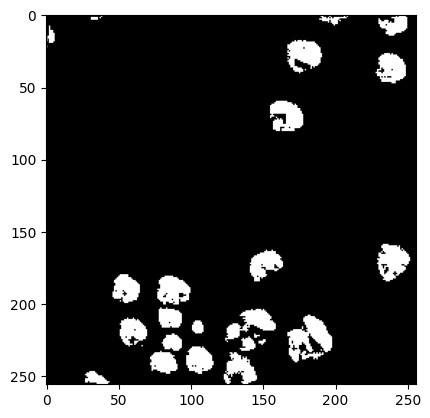

In [4]:
import matplotlib.pyplot as plt
plt.imshow(mask[0,:,:],cmap="gray")